# Monte Carlo Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

---

The `csr` function implement the completely spatially random point process in a rectangular region. It returns the $x$- and $y$- coordinates of the simulated points.

In [2]:
def csr(lam, window=[0, 1, 0, 1]):
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    N = np.random.poisson(lam*area)
    x_list = np.random.uniform(x_min, x_max, N)
    y_list = np.random.uniform(y_min, y_max, N)
    return x_list, y_list

<b>Example<b>:

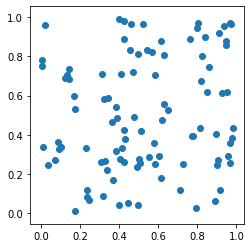

In [3]:
x, y = csr(100) # simulate csr with intensity 100
plt.scatter(x, y) # plot the point pattern
axes = plt.gca()
axes.set_aspect('equal')

---

The `k_estimate` function estimates the $K$-function of the input point pattern by Ripley's edge-corrected estimator. It returns an array of values $\hat{K}(r)$ and the corresponding array of $r$ values.

In [4]:
def k_estimate(x, y, window=[0, 1, 0, 1], n=200, r_max=None):
    points = np.column_stack((x, y))
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    N = len(points)
    lam_hat = N/area
    
    u = squareform(pdist(points)) + np.eye(N)
    d1 = np.minimum(x - x_min, x_max - x)
    d2 = np.minimum(y - y_min, y_max - y)
    d1 = np.tile(d1, (N, 1))
    d2 = np.tile(d2, (N, 1))
    d_hypot = np.hypot(d1, d2)
    
    w1 = 1 - 1/np.pi*(np.arccos(np.minimum(d1, u)/u) + np.arccos(np.minimum(d2, u)/u))
    uu = u.copy()
    uu[uu < d_hypot] = d_hypot[uu < d_hypot]
    w2 = 3/4 - 1/(2*np.pi)*(np.arccos(d1/uu) + np.arccos(d2/uu))
    
    d_hypot = np.hypot(d1, d2)
    w_ind = u <= d_hypot
    w = w_ind*w1 + ~w_ind*w2
    u -= np.eye(N)
    
    if not r_max:
        r_max = min(y_max-y_min, x_max-x_min)/2
    
    r = np.linspace(0, r_max, n)
    k = np.zeros(n)
    for i in range(n):
        d_ind = (u < r[i]) & (u > 0)
        k[i] = np.sum((d_ind/w)/N/lam_hat)
    
    return r, k

<b>Example<b>:

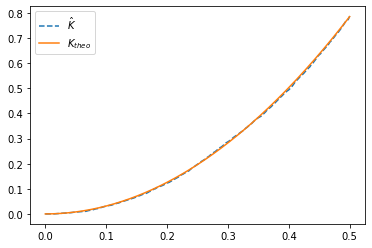

In [5]:
x, y = csr(100) # generate a csr point pattern
r, k = k_estimate(x, y) # estimate the K-function for the point pattern
plt.plot(r, k, ls='--', label=r'$\hat{K}$') # plot
plt.plot(r, np.pi*r**2, label=r'$K_{theo}$')
plt.legend()

---

The `l_estimate` function estimates the $L$-function of the input point pattern. It is calculated by $\hat{L}(r) = \sqrt{\hat{K}(r)/\pi}$. It returns an array of values $\hat{L}(r)$ and the corresponding array of $r$ values.

In [6]:
def l_estimate(x, y, **kwargs):
    r, k = k_estimate(x, y, **kwargs)
    l = np.sqrt(k/np.pi)
    return r, l

<b>Example<b>:

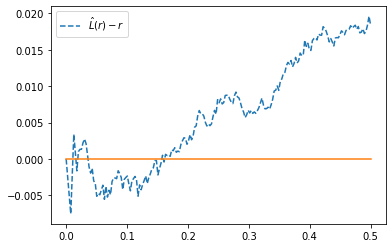

In [7]:
x, y = csr(100) # generate a csr point pattern
r, l = l_estimate(x, y) # estimate the L-function for the point pattern
plt.plot(r, l-r, ls='--', label=r'$\hat{L}(r)-r$') # plot L(r)-r v.s. r
plt.plot(r, r*0)
plt.legend()

---

The `test_statistic` function returns the test statistic $T = \sup{|\hat{L}(r) - r|}$ for $r < r_\text{max}$ of the input point pattern.

In [8]:
def test_statistic(x, y, **kwargs):
    r, l = l_estimate(x, y, **kwargs)
    return abs(max(l - r, key=abs))

<b>Example:<b>

In [9]:
x, y = csr(100) # generate a csr point pattern
test_statistic(x, y) # calculate the test statistic

0.013216727052337618

---

The `csr_critical_value` returns the critical value of the test statistic $T = \sup{|\hat{L}(r) - r|}$ at a level $1-\alpha$. A number of CSR processes are simulated with intensity $\lambda = \hat{\lambda}$ where $\hat{\lambda}$ is the observed intensity of the input point pattern. For each simulation a statistic $t_i$ is calculated and the critical value is the $1-\alpha$ quantile of the set $\{t_i\}$.

In [10]:
def csr_critical_value(x, y, window=[0, 1, 0, 1], alpha=0.05, nsim=99, **kwargs):
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    lam_hat = len(x)/area
    
    l_stats = np.zeros(nsim)
    
    for i in range(nsim):
        xx, yy = csr(lam_hat, window=window)
        sup_l = test_statistic(xx, yy)
        l_stats[i] = sup_l
    
    return np.quantile(l_stats, 1-alpha)

<b>Example:<b>

In [11]:
x, y = csr(100) # generate a csr point pattern
c = csr_critical_value(x, y, alpha=0.05, nsim=200) # calculate the 95% critical value
t = test_statistic(x, y) # calculate the test statistic
t < c # compare t with critical value

True